In [1]:
import pyecap
import os
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.io as sio
from fnirs_functions import *

In [7]:
fnirs_data = sio.loadmat(r'M:\Projects\fNIRs_QC\20260206_0-1Hz_fNIRS\fNIRS\run10.mat', struct_as_record=True)

In [10]:
fnirs_data['data'][0,0]['raw_data']

array([[ 999734.        , 1204445.        ,   -5341.        , ...,
         735739.        , 1330589.        ,  680657.        ],
       [ 999584.        , 1204163.        ,  -13864.        , ...,
         734114.        , 1328964.        ,  679019.        ],
       [ 999525.        , 1204057.        ,  -10055.        , ...,
         734480.        , 1328968.        ,  679189.        ],
       ...,
       [ 997140.        , 1195854.        ,  -10934.        , ...,
         717364.        , 1268013.        ,  649177.        ],
       [ 997221.        , 1196030.        ,   -9842.00000003, ...,
         715936.99999999, 1266740.99999999,  648275.99999999],
       [ 997349.        , 1196221.        ,   -4753.        , ...,
         718443.        , 1269429.        ,  650709.        ]],
      shape=(81192, 12))

In [127]:
meta_index = 7
metaDF = pd.read_excel(r'M:\Projects\fNIRs_QC\20260206_0-1Hz_fNIRS\meta.xlsx')

tank = metaDF.at[meta_index, 'Tank']
flex_folder = metaDF.loc[meta_index, 'fNIRs Folder']

#stim = pyecap.Stim(r'M:\Projects\fNIRs_QC\20260206_0-1Hz_fNIRS\CVP_SingleCh_Ramp-260206\S113-260206-141915')
stim = pyecap.Stim(tank)
stimDF = stim.parameters
#fnirsDF = flex_import(flex_folder)

ValueError: no field of name Time (s)

In [107]:
"""Plotly plot for looking at stim artifact in flexNIRs data"""
channel = 'D3 Ambient'

fig = go.Figure()
fig.add_trace(go.Scatter(x = fnirsDF.index, y = fnirsDF[channel]))
fig.update_traces(hovertemplate = '%{x:.0f}')
fig.show()

In [108]:
"""High pass filter for finding artifact"""
fs = 800/3
filter_cutoffs = 1
transition_width = 1
numtaps = 3001
#numtaps = int(( 3.3 * fs) / (2 * transition_width)) * 2 + 1

filter_weights = signal.firwin(numtaps, filter_cutoffs, width=transition_width, window='Hamming', pass_zero = 'highpass', fs=fs)

#Plot Frequency Response
w,h = signal.freqz(filter_weights, worN = fft.next_fast_len(40000, real=True))
# plt.plot( (w / np.pi) * (fs/2), 20 * np.log10( np.abs(h)))
# plt.xlim((0,200))

artDF = fnirsDF.copy()

"""flexNIRs High-pass Artifact Filtering -- WIP"""
data_cols = ['D1 Ambient','D3 Ambient']
for col in data_cols:
    data = artDF[col].to_numpy()
    padded_data = data #pad_noise(data, numtaps, 5000)
    filtered_data = np.flip(signal.fftconvolve(np.flip(signal.fftconvolve(padded_data, filter_weights, mode='same')), filter_weights, mode='same'))
    name = col + ' Filtered'
    artDF[name] = filtered_data#[numtaps:-numtaps]

"""Plotly plot for looking at stim artifact in flexNIRs data"""
channel = 'D3 Ambient Filtered'

fig = go.Figure()
fig.add_trace(go.Scatter(x = artDF['Time (s)'], y = artDF[channel], customdata = artDF.index, hovertemplate = '%{customdata:.1f}'))
fig.show()

# for param in stimDF.index:
#     fig.add_vrect(x0 = stimDF.loc[param]['fNIRs onset time (s)'], x1 = stimDF.loc[param]['fNIRs offset time (s)'])

In [109]:
"""Manual alignment funciton - requires manual ID and input of the first stimulation start index"""
DF2 = pd.DataFrame()
DF2 = stimDF.loc[ stimDF['pulse amplitude (μA)'] < 0]
alignDF = manual_alignment(fnirsDF, DF2, stim_start_index=61*266)

"""Plotly plot for looking at stim artifact in flexNIRs data"""
channel = 'D3 Ambient Filtered'

fig = go.Figure()
fig.add_trace(go.Scatter(x = artDF['Time (s)'], y = artDF[channel], customdata = artDF.index, hovertemplate = '%{customdata:.1f}'))

for param in alignDF.index:
    fig.add_vrect(x0 = alignDF.loc[param]['fNIRs onset time (s)'], x1 = alignDF.loc[param]['fNIRs offset time (s)'])
fig.show()

In [110]:
fnirsDF = fnirs_filter(fnirsDF, device_type = 'flexNIRs', filter_cutoffs = (0.01,1))
#fnirs_plot(fnirsDF, alignDF, channel = 'SS', device_type = 'flexNIRs', pre_time = 0, post_time=0)

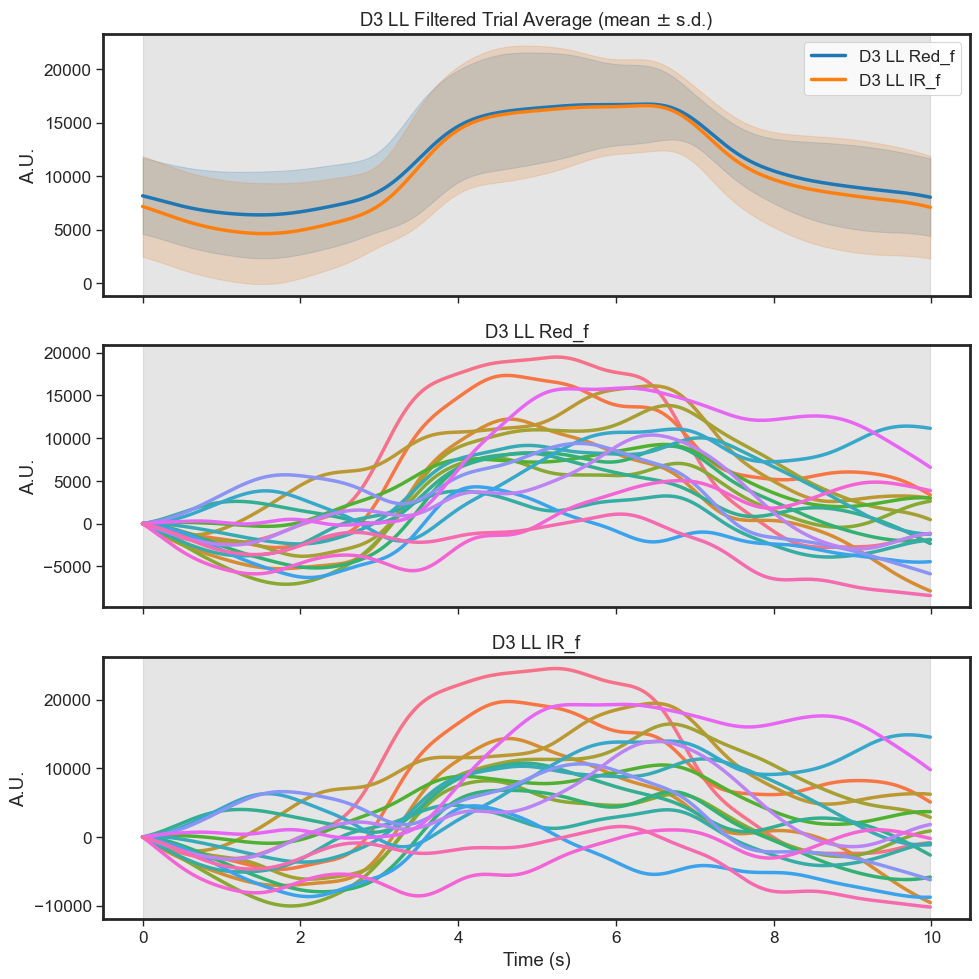

In [116]:
fnirs_plot(fnirsDF, alignDF, channel = 'D3 LL Filtered', device_type = 'flexNIRs', pre_time = 0, post_time=0, plot_type = 'Full', zero_shift = True)

In [125]:
"""Trying to recreate Harvard data pipeline in python
- Pass each signal through a median filter
- Pass each signal through a bandpass filter (.001 - 0.18) on top of a -log(signal / (mean(signal)) to get delta OD
- Calculates differential path length factor for each channel
- Calculates change in absorption coefficient based on deltaOD / dpf
- Calculates change in HB using MBLL matrix multiplication against extinction coefficients
"""
wavelengths = [760,850]
sds = [2.8,3.3] # Source-detector-separation distances
msp0 = 6.666
mspb = 0.99
wv0 = 750
waterP = 0.75
msp = [msp0*(wv/wv0)**(-mspb) for wv in wavelengths]
extinctionC = np.array([[1349.558, 3910.494,0.0252],[2436.574,1888.46,0.043]])

In [129]:
fnirs_data = sio.loadmat(r'M:\Projects\fNIRs_QC\20260206_0-1Hz_fNIRS\fNIRS\run10.mat')